<a href="https://colab.research.google.com/github/Ayushimahajan876/AyushiMahajan_GoogleGirlHackathon_Ideathon_2024/blob/main/Ayushi_Mahajan_Google_Girl_Hackathon_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install tensorflow seaborn matplotlib pandas opencv-python numpy Pillow

In [ ]:
###############################it is a prototype how my model will look like ########################

In [2]:
from google.colab import drive
drive.mount('/content/myDrive/')

Mounted at /content/myDrive/


In [70]:
import os
import tensorflow as tf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping
from PIL import ImageFile
import scipy as sp

In [4]:
# List physical devices
for device in tf.config.list_physical_devices():
    print(device.name)

# Set TensorFlow version for Colab
try:
    get_ipython().run_line_magic('tensorflow_version', '2.x')
except Exception:
    pass

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Allow truncated images to load
ImageFile.LOAD_TRUNCATED_IMAGES = True

/physical_device:CPU:0
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
#The below code is used for image preprocessing and model training to make each
# Set image size for resizing

im_size = 224

#setting image size

image_resize = (im_size, im_size, 3)

# Set batch sizes
batch_size_training = 100
batch_size_test = 100
batch_size_validation = 100

# Set number of classes
num_classes = 2

In [6]:
wildfire_train_path = "/content/myDrive/MyDrive/train"
wildfire_valid_path = "/content/myDrive/MyDrive/valid"
wildfire_test_path = "/content/myDrive/MyDrive/test"

In [7]:
data_generator = ImageDataGenerator(dtype='float32', rescale=1./255.)


In [8]:
wildfire_train_generator = data_generator.flow_from_directory(wildfire_train_path,
                                                   batch_size = batch_size_training,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

wildfire_valid_generator = data_generator.flow_from_directory(wildfire_valid_path ,
                                                   batch_size = batch_size_validation,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

wildfire_test_generator = data_generator.flow_from_directory(wildfire_test_path ,
                                                   batch_size = batch_size_test,
                                                   target_size = (im_size, im_size),
                                                   class_mode = 'categorical')

Found 30542 images belonging to 2 classes.
Found 6313 images belonging to 2 classes.
Found 6340 images belonging to 2 classes.


In [9]:
#number of classes in our target it will give 0 and 1 since no-wildfire and wildfire are the only 2 conditions
class_mapping = wildfire_train_generator.class_indices
class_mapping

{'nowildfire': 0, 'wildfire': 1}

In [10]:
#since the dataset is divided into batches the below code will give the first batch among all training datasets and it is ready to be fed on the model
first_batch_train = wildfire_train_generator.next()
first_batch_train

(array([[[[0.01176471, 0.03137255, 0.04705883],
          [0.00784314, 0.02745098, 0.04313726],
          [0.00784314, 0.02745098, 0.04313726],
          ...,
          [0.13333334, 0.2509804 , 0.15686275],
          [0.12941177, 0.2392157 , 0.14901961],
          [0.2392157 , 0.33333334, 0.24705884]],
 
         [[0.01176471, 0.03137255, 0.04705883],
          [0.00784314, 0.02745098, 0.04313726],
          [0.00784314, 0.02745098, 0.04313726],
          ...,
          [0.16078432, 0.28627452, 0.19215688],
          [0.18039216, 0.29803923, 0.20392159],
          [0.25490198, 0.3529412 , 0.26666668]],
 
         [[0.01176471, 0.03137255, 0.04705883],
          [0.00784314, 0.02745098, 0.04313726],
          [0.00784314, 0.02745098, 0.04313726],
          ...,
          [0.09803922, 0.22352943, 0.12941177],
          [0.11764707, 0.24313727, 0.14901961],
          [0.22352943, 0.33333334, 0.24313727]],
 
         ...,
 
         [[0.01176471, 0.02745098, 0.03137255],
          [0.01176

In [11]:
#class names in training dataset
wildfire_class_names = list(wildfire_train_generator.class_indices.keys())
print("Class names :",wildfire_class_names)

Class names : ['nowildfire', 'wildfire']


In [12]:
#class names in valid dataset
wildfire_class_names_valid = list(wildfire_valid_generator.class_indices.keys())
print("Class names :",wildfire_class_names_valid)

Class names : ['nowildfire', 'wildfire']


In [13]:
#class names in test dataset
wildfire_class_names_test = list(wildfire_test_generator.class_indices.keys())
print("Class names :",wildfire_class_names_test)

Class names : ['nowildfire', 'wildfire']


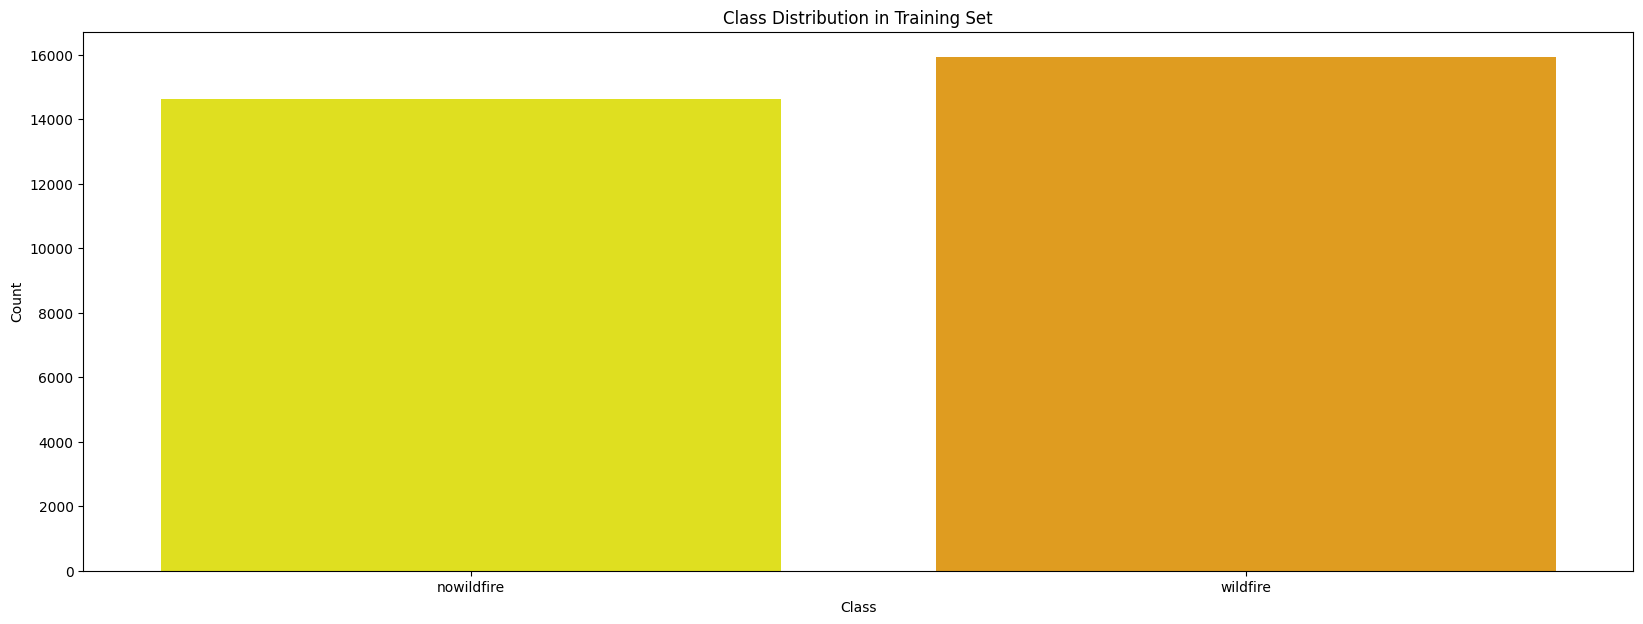

In [14]:
custom_palette = {'nowildfire': 'yellow', 'wildfire': 'orange'}

data = pd.DataFrame({'Class': wildfire_class_names, 'Count': [sum(wildfire_train_generator.labels == c) for c in range(num_classes)]})

plt.figure(figsize=(20, 7))
sns.barplot(x='Class', y='Count', data=data, palette=custom_palette)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [15]:
#Below code will count the unique labels which will be equal to 2 and number of images belonging to wildfire and notwildfire class in training dataset
labels_train = wildfire_train_generator.classes
unique_labels_train, label_counts_train = np.unique(labels_train, return_counts=True)

print("Number of  labels in training data used for wildfire prediction:", len(unique_labels_train))
for label, count in zip(unique_labels_train, label_counts_train):
    print("Label:", wildfire_class_names[label], "- Count:", count)

Number of  labels in training data used for wildfire prediction: 2
Label: nowildfire - Count: 14621
Label: wildfire - Count: 15921


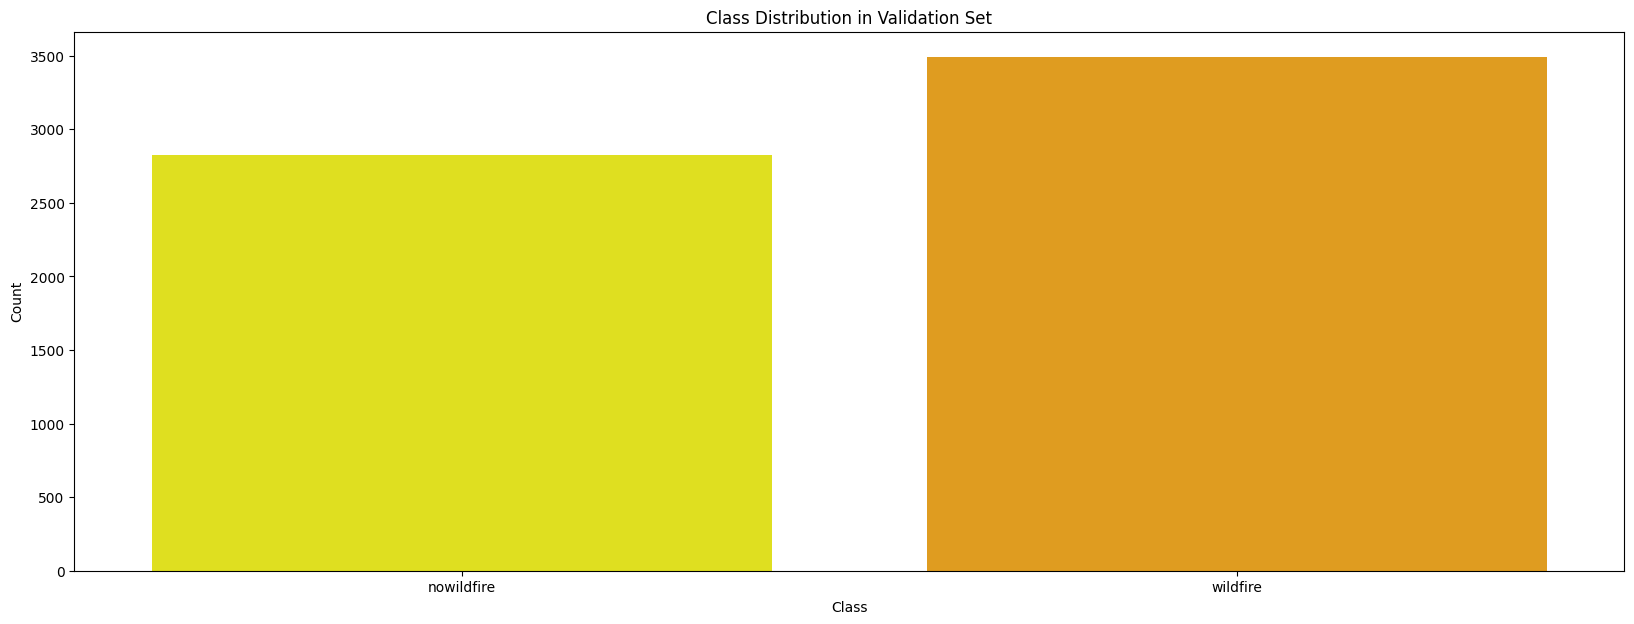

In [16]:
ustom_palette = {'nowildfire': 'yellow', 'wildfire': 'orange'}

data = pd.DataFrame({'Class': wildfire_class_names, 'Count': [sum(wildfire_valid_generator.labels == c) for c in range(num_classes)]})

plt.figure(figsize=(20, 7))
sns.barplot(x='Class', y='Count', data=data, palette=custom_palette)
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [17]:
labels_valid = wildfire_valid_generator.classes
unique_labels_valid, label_counts_valid = np.unique(labels_valid, return_counts=True)

print("Number of unique labels in valid data:", len(unique_labels_valid))
for label, count in zip(unique_labels_valid, label_counts_valid):
    print("Label:", wildfire_class_names_valid[label], "- Count:", count)


Number of unique labels in valid data: 2
Label: nowildfire - Count: 2824
Label: wildfire - Count: 3489


In [18]:
%ls /content/myDrive/MyDrive/models

wildfire_CNN_model = load_model('/content/myDrive/MyDrive/models/kerasModel.h5')

kerasModel.h5


In [19]:
def base_model(input_shape, repetitions):

  input_ = tf.keras.layers.Input(shape=input_shape, name='input')
  x = input_

  for i in range(repetitions):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

  return x, input_

In [20]:
def final_model(input_shape, repetitions):

    x, input_ = base_model(input_shape, repetitions)

    x = Conv2D(64, 3, activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    class_out = Dense(num_classes, activation='softmax', name='class_out')(x)

    model = Model(inputs=input_, outputs=class_out)

    print(model.summary())
    return model

In [21]:
#final CNN model

wildfire_CNN_model = final_model(image_resize, 4)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 32)      128   

In [22]:
#remove existing logs before starting training the model

get_ipython().system('rm -rf logs')

In [23]:
#model is configured keeping in mind the accuracy to produce accurate results
wildfire_CNN_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('saved_model/custom_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint, tensorboard_callback]

In [ ]:
# #Training dataset(i.e. satellite imagery) is passed 1 times through CNN
# num_epochs = 1
# #Number of steps(batches) sent per epoch
# steps_per_epoch_wildfire_training = len(wildfire_train_generator)
# steps_per_epoch_wildfire_validation = len(wildfire_valid_generator)

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping callback
wildfire_trained_CNN_model = wildfire_CNN_model.fit(
    wildfire_train_generator,
    epochs=2,
    callbacks=[early_stopping],
    validation_data=wildfire_test_generator,
    verbose=1  # Set verbose mode to see training progress
)

Epoch 1/2
306/306 [==============================] - 3698s 12s/step - loss: 0.0658 - accuracy: 0.9761 - val_loss: 0.2493 - val_accuracy: 0.8917
Epoch 2/2
306/306 [==============================] - 2779s 9s/step - loss: 0.0597 - accuracy: 0.9775 - val_loss: 0.0979 - val_accuracy: 0.9691


In [57]:
#After training the Model ,Let's analyse the model accuracy via plots of accuracy and loss
wildfire_CNN_model .save('/content/myDrive/MyDrive/models/custom_model')
print("Model saved!")

Model saved!


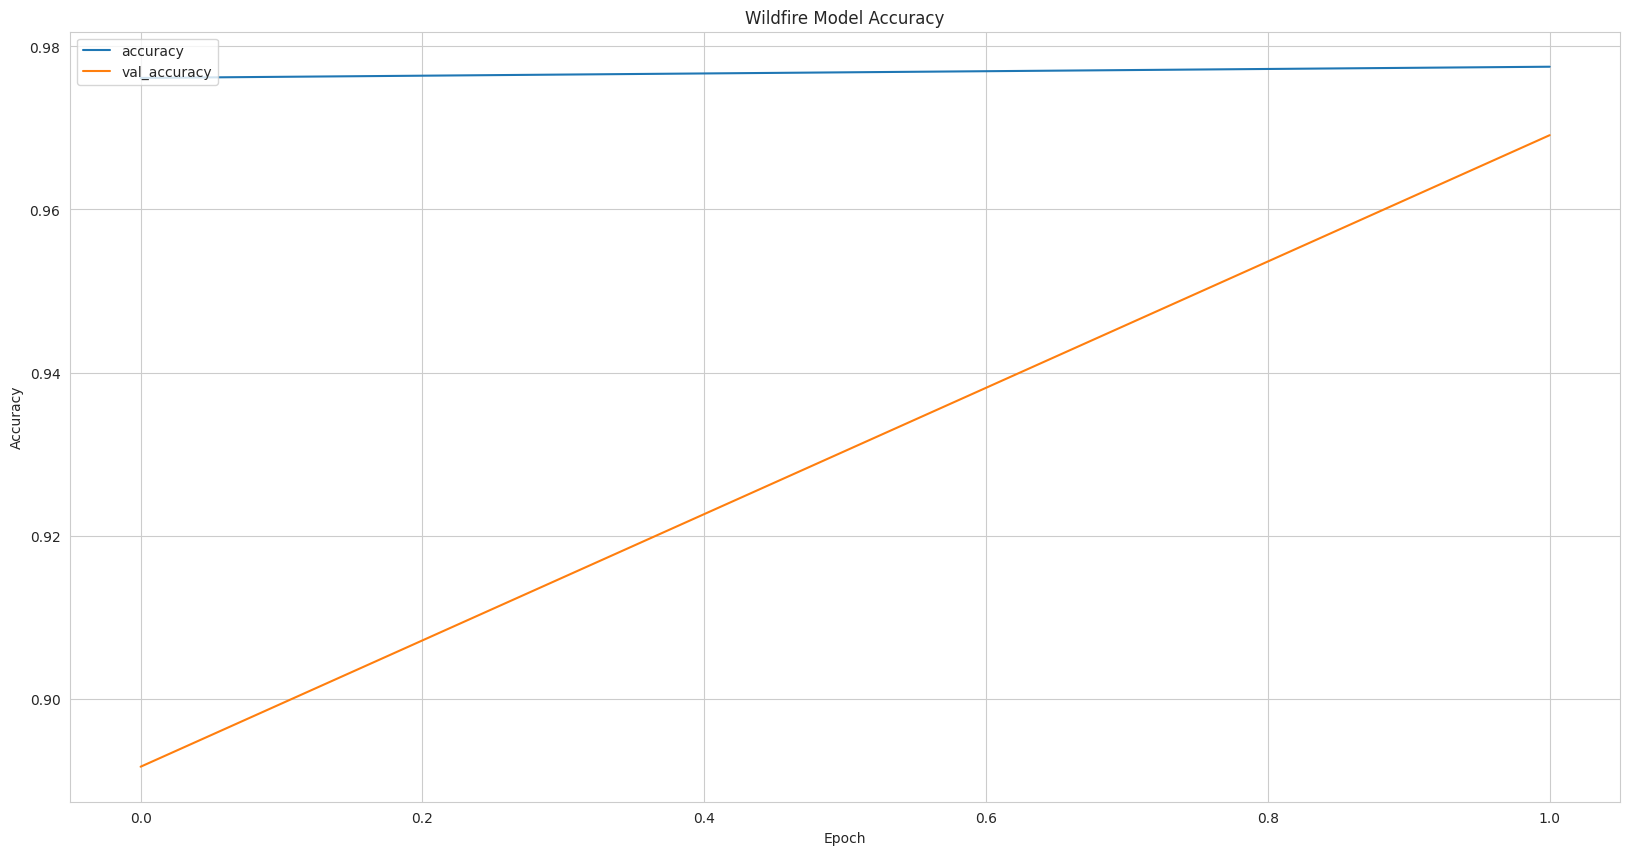

In [58]:
#plot for model accuracy
def plot_acc(wildfire_trained_model_CNN):
  plt.figure(figsize=(20, 10))
  sns.set_style('whitegrid')
  plt.plot(wildfire_trained_model_CNN.history['accuracy'])
  plt.plot(wildfire_trained_model_CNN.history['val_accuracy'])
  plt.title('Wildfire Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
  plt.show()
plot_acc(wildfire_trained_CNN_model)


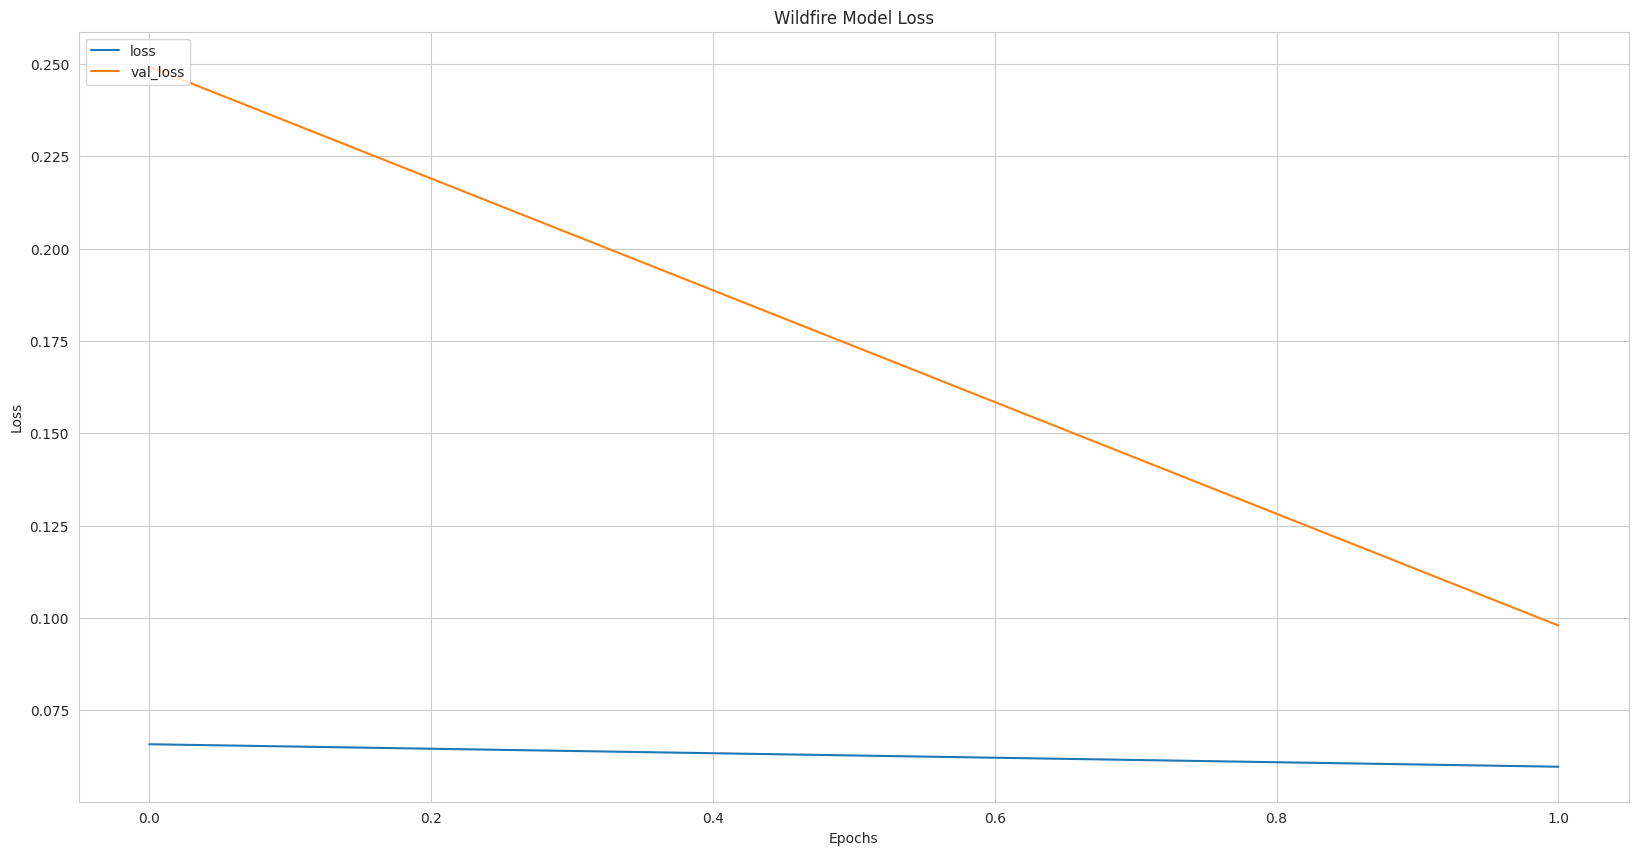

In [59]:
# plot for model loss
def plot_loss(wildfire_trained_model_CNN ):
  plt.figure(figsize=(20, 10))
  sns.set_style('whitegrid')
  plt.plot(wildfire_trained_model_CNN .history['loss'])
  plt.plot(wildfire_trained_model_CNN .history['val_loss'])
  plt.title('Wildfire Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()
plot_loss(wildfire_trained_CNN_model)

In [ ]:
#Now we have are done with data preprocessing,rescaling,loading,Model training and analysing the model
#Let's dive into the exciting part i.e. testing the data (how well our model behaves in case of unseen data)
#made the data frames for prediction

In [60]:
filenames = wildfire_test_generator.filenames
wildfire_predictions = wildfire_CNN_model.predict_generator(wildfire_test_generator, steps=len(wildfire_test_generator), verbose=1).round(3)

64/64 [==============================] - 212s 3s/step


In [61]:
filenames_df = pd.DataFrame(filenames, columns=['File Path'])
predicted_df = pd.DataFrame(wildfire_predictions, columns=['No Wildfire Probability', 'Wildfire Probability'])
model_predictions = pd.concat([filenames_df, predicted_df], axis=1)
model_predictions

,File Path,No Wildfire Probability,Wildfire Probability
0,"nowildfire/-113.91777,50.901087.jpg",0.972,0.028
1,"nowildfire/-113.91782,50.896917.jpg",0.000,1.000
2,"nowildfire/-113.91793,51.091205.jpg",0.010,0.990
3,"nowildfire/-113.918016,50.978447.jpg",0.989,0.011
4,"nowildfire/-113.918155,51.129969.jpg",1.000,0.000
...,...,...,...
6335,"wildfire/-79.48666,47.60672.jpg",0.000,1.000
6336,"wildfire/-79.489,49.16667.jpg",0.665,0.335
6337,"wildfire/-79.49726,48.89808.jpg",0.933,0.067
6338,"wildfire/-79.50932,48.06745.jpg",0.000,1.000


In [62]:
# Predictions made by the model are saved to CSV file named model_predictions
file_name='/content/myDrive/MyDrive/model_predictions.csv'
model_predictions.to_csv(file_name, sep=',', encoding='utf-8')

In [ ]:
#once the model is trained we can just put the image and detect it using simple technique
#But to make the model (CNN model)work more accurate and more efficient we will build CAM(Class Activation Map for the input image) and then classify

In [63]:
outputs = [layer.output for layer in wildfire_CNN_model.layers[1:9]]

In [64]:
visualize_model = Model(wildfire_CNN_model.input, outputs)
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])
print("Layers that will be used for visualization: ")
print(layer_names)

Layers that will be used for visualization: 
['conv2d', 'batch_normalization', 'max_pooling2d', 'conv2d_1', 'batch_normalization_1', 'max_pooling2d_1', 'conv2d_2', 'batch_normalization_2']


In [65]:
gap_weights = wildfire_CNN_model.layers[-1].get_weights()[0]
gap_weights.shape
cam_model  = Model(inputs=wildfire_CNN_model.input, outputs=(wildfire_CNN_model.layers[-3].output,wildfire_CNN_model.layers[-1].output))
cam_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 32)      128 

In [66]:
cam_model.save('/content/myDrive/MyDrive/models/cam_model')
print("Model saved!")

Model saved!


In [78]:
def show_cam(image_value, features, results):

  features_for_img = features[0]
  prediction = results[0]

  class_activation_weights = gap_weights[:,0]
  class_activation_features = sp.ndimage.zoom(features_for_img, (im_size/10, im_size/10, 1), order=2)
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # Visualize the results
  plt.figure(figsize=(12, 12))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.title('Class Activation Map')
  #show the probabilites of wildfire and no wildfire
  plt.figtext(.5, .05, f"No Wildfire Probability: {results[0][0] * 100}%\nWildfire Probability: {results[0][1] * 100}%", ha="center", fontsize=12, bbox={"facecolor":"green", "alpha":0.5, "pad":3})
  plt.colorbar()
  plt.show()

In [79]:
#image will be the input and it is converted to CAM(class activation map) and is classified whether there is wildfire probablity or not
def convert_and_classify(image):

  img = cv2.imread(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = cv2.resize(img, (im_size, im_size)) / 255.0
  tensor_image = np.expand_dims(img, axis=0)
  features, results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)



1/1 [==============================] - 0s 69ms/step


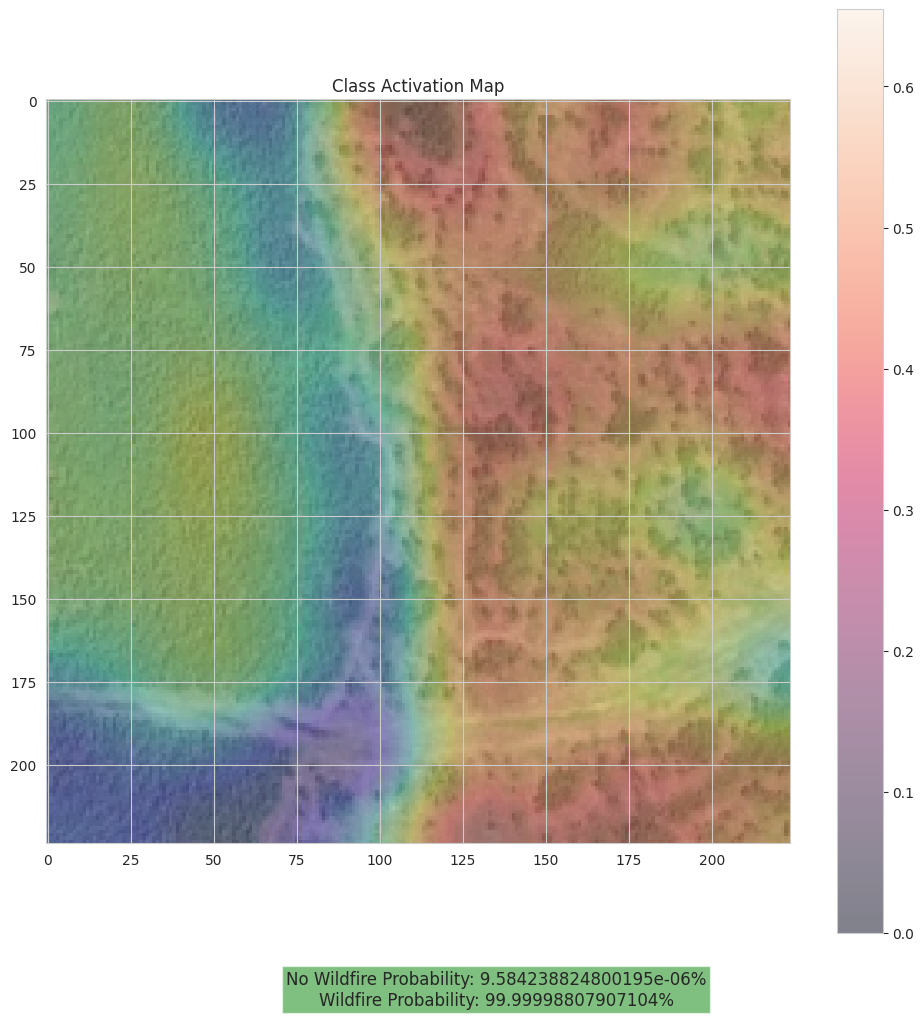

In [95]:
convert_and_classify('/content/myDrive/MyDrive/wildfire_image.jpg')

1/1 [==============================] - 0s 43ms/step


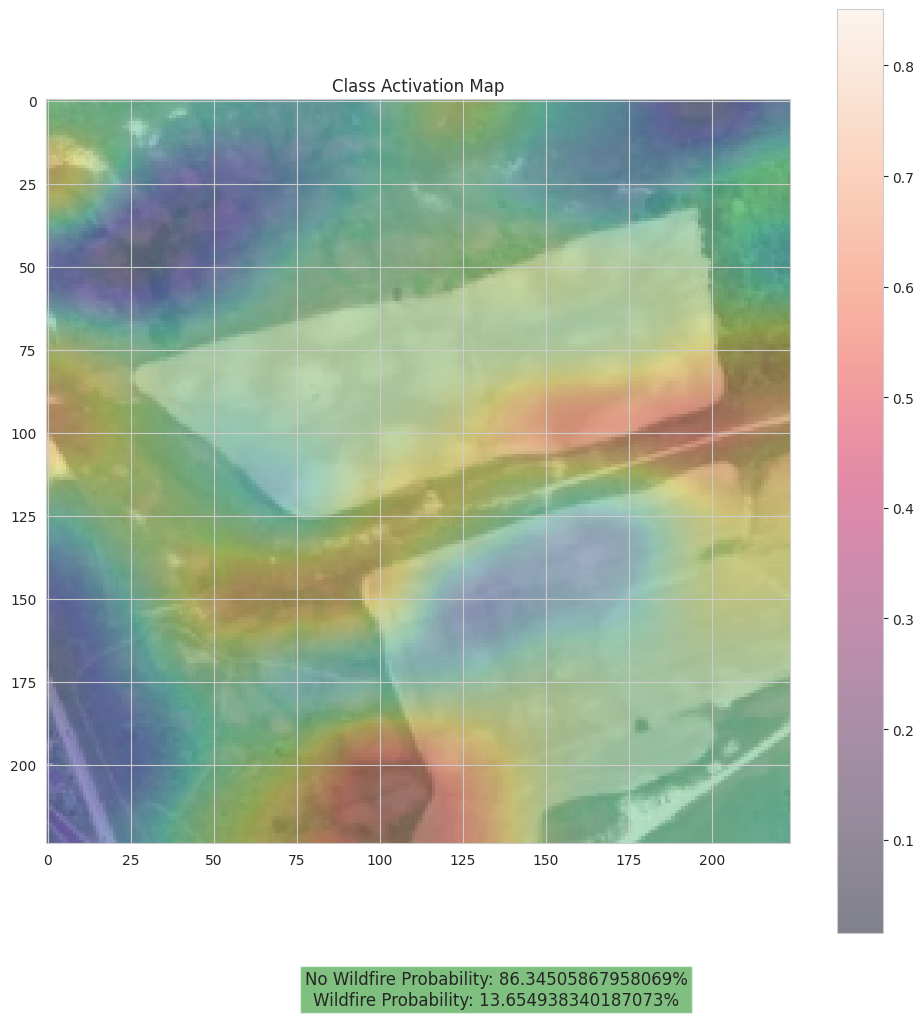

In [96]:
convert_and_classify('/content/myDrive/MyDrive/no_wildfire_image.jpg')